### Below is the code for Kaggle house price competition. The prediction was in top 1% of all scores.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Data prep

In [3]:
data = pd.read_csv('./kaggle_hous/train.csv')

Y = data['SalePrice']
X = data.drop(columns=["SalePrice", "Id"])
X_test = pd.read_csv('./kaggle_hous/test.csv', index_col="Id")

<Axes: >

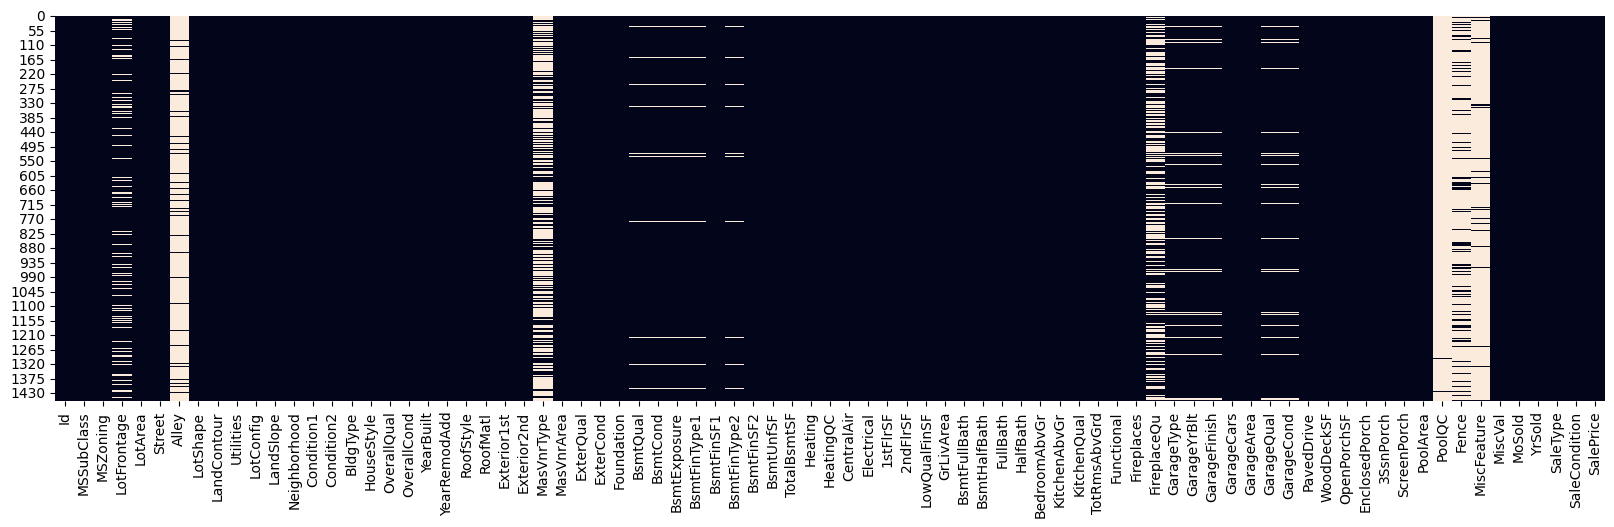

In [4]:
null_plot = data.isna()
plt.figure(figsize=(20,5))
sns.heatmap(null_plot, cbar=False)


When it comes to 'Alley' feature, NaN value means there is no alley access, so it still contains valuable information. Same goes for the fence, fireplaces, garage features and a few others.
Similarely, MasVnrType with value NaN means there is no masonry veneer present. It is unclear why most houses indicate none while still having data for its area but removing those features lowered the prediction accuracy.

LotFrontage will need to be either imputed or discarded. One value missing for elecrical system type. PoolQC is pool quality, NaN also means the house does not have a pool. Only a few houses have one, perhaps it makes sense to give it some importance in the model. Similarely with MiscFeatures, which can mean any Miscellanous feature like an elevator.

Prepare some dictionaries for ordinal encoding. A lot of features in the dataset are ordinal in nature so the model might benefit from correct ordinal encoding. I will test it later against OH encoding on all features. Added those only for some featurers, where it seemed most impactful.

In [62]:
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = list(set(X.columns) - set(categorical_cols))
X[categorical_cols] = X[categorical_cols].astype(dtype='category')

In [4]:
quality_feat = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1}
#Excellent, Good, Average, Fair, Poor
finish_feat = {"Fin":3, "RFn":2, "GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1} #garage Fin Rfn Unf
                                                                                                #basement GLQ ALQ BLQ Rec LwQ Unf
# foundation_feat = {'PConc':4, 'CBlock':5, 'BrkTil':6, 'Wood':1, 'Slab':3, 'Stone':2}
electrical_feat = {'SBrkr':3, 'FuseF':2, 'FuseA':3, 'FuseP':1, 'Mix':2}
functional_feat = {'Typ':6, 'Min1':5, 'Maj1':3, 'Min2':5, 'Mod':4, 'Maj2':3, 'Sev':2, 'Sal':1}
pavement_feat = {'Grvl':1, 'Pave':0}
roof_type = {'CompShg':7, 'WdShngl':0, 'Metal':5, 'WdShake':1, 'Membran':6, 'Tar&Grv':3,
       'Roll':4, 'ClyTile':8}

fet_mapping_list = [quality_feat, finish_feat, electrical_feat, functional_feat, pavement_feat, roof_type]

get_features_containing(data, feat_dict): function to get names of features that contain values in encoder dictionary

get_OrEncoder_mapping(fet_mapping_list): function to create maps from defined dictionaries in the format of 
                                         OrdinalEncoder [{'col': feature_name, 'mapping': feature_map}, {...}]

get_all_ordinal_features(data, mapping_list): get a full list of all feature names used with ordinal encoder

In [5]:
def get_features_containing(data, feat_dict):
    features = data.isin( list(feat_dict.keys()) ).sum()
    return list(features[features > 0].index)

def get_OrEncoder_mapping(fet_mapping_list):
    mapping = []

    for encode_params in fet_mapping_list:
        feature_names = get_features_containing(X, encode_params)

        for name in feature_names:
            mapping.append({'col': name, 'mapping': encode_params})
            
    return mapping

def get_all_ordinal_features(data, mapping_list):
    temp = []
    for i in mapping_list:
        temp.append( get_features_containing(data, i) )
    return [i for sl in temp for i in sl]

In [158]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import SelectKBest

Split the data into training and validation batches.

In [237]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=1)

### 2. Create preprocessing and training pipeline

In [238]:
Ordinal_cols = get_all_ordinal_features(X, fet_mapping_list)
OH_cols = list(set(categorical_cols)-set(get_all_ordinal_features(X, fet_mapping_list)))

numerical_transformer = SimpleImputer(strategy='mean')
ordinal_encoder = OrdinalEncoder(mapping=get_OrEncoder_mapping(fet_mapping_list), return_df=True)
OH_encoder = OneHotEncoder(return_df=True, use_cat_names=True)

categorical_transformer = ColumnTransformer(transformers=[
    ('ordinal_columns', ordinal_encoder, Ordinal_cols),
    ('OH_columns', OH_encoder, OH_cols)
])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', numerical_transformer, numerical_cols),
    ('categorical', categorical_transformer, categorical_cols)
])

full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', XGBRegressor(n_estimators=200, max_depth=3))
])

Preprocessing the data allows for corralation analysis.

<Axes: >

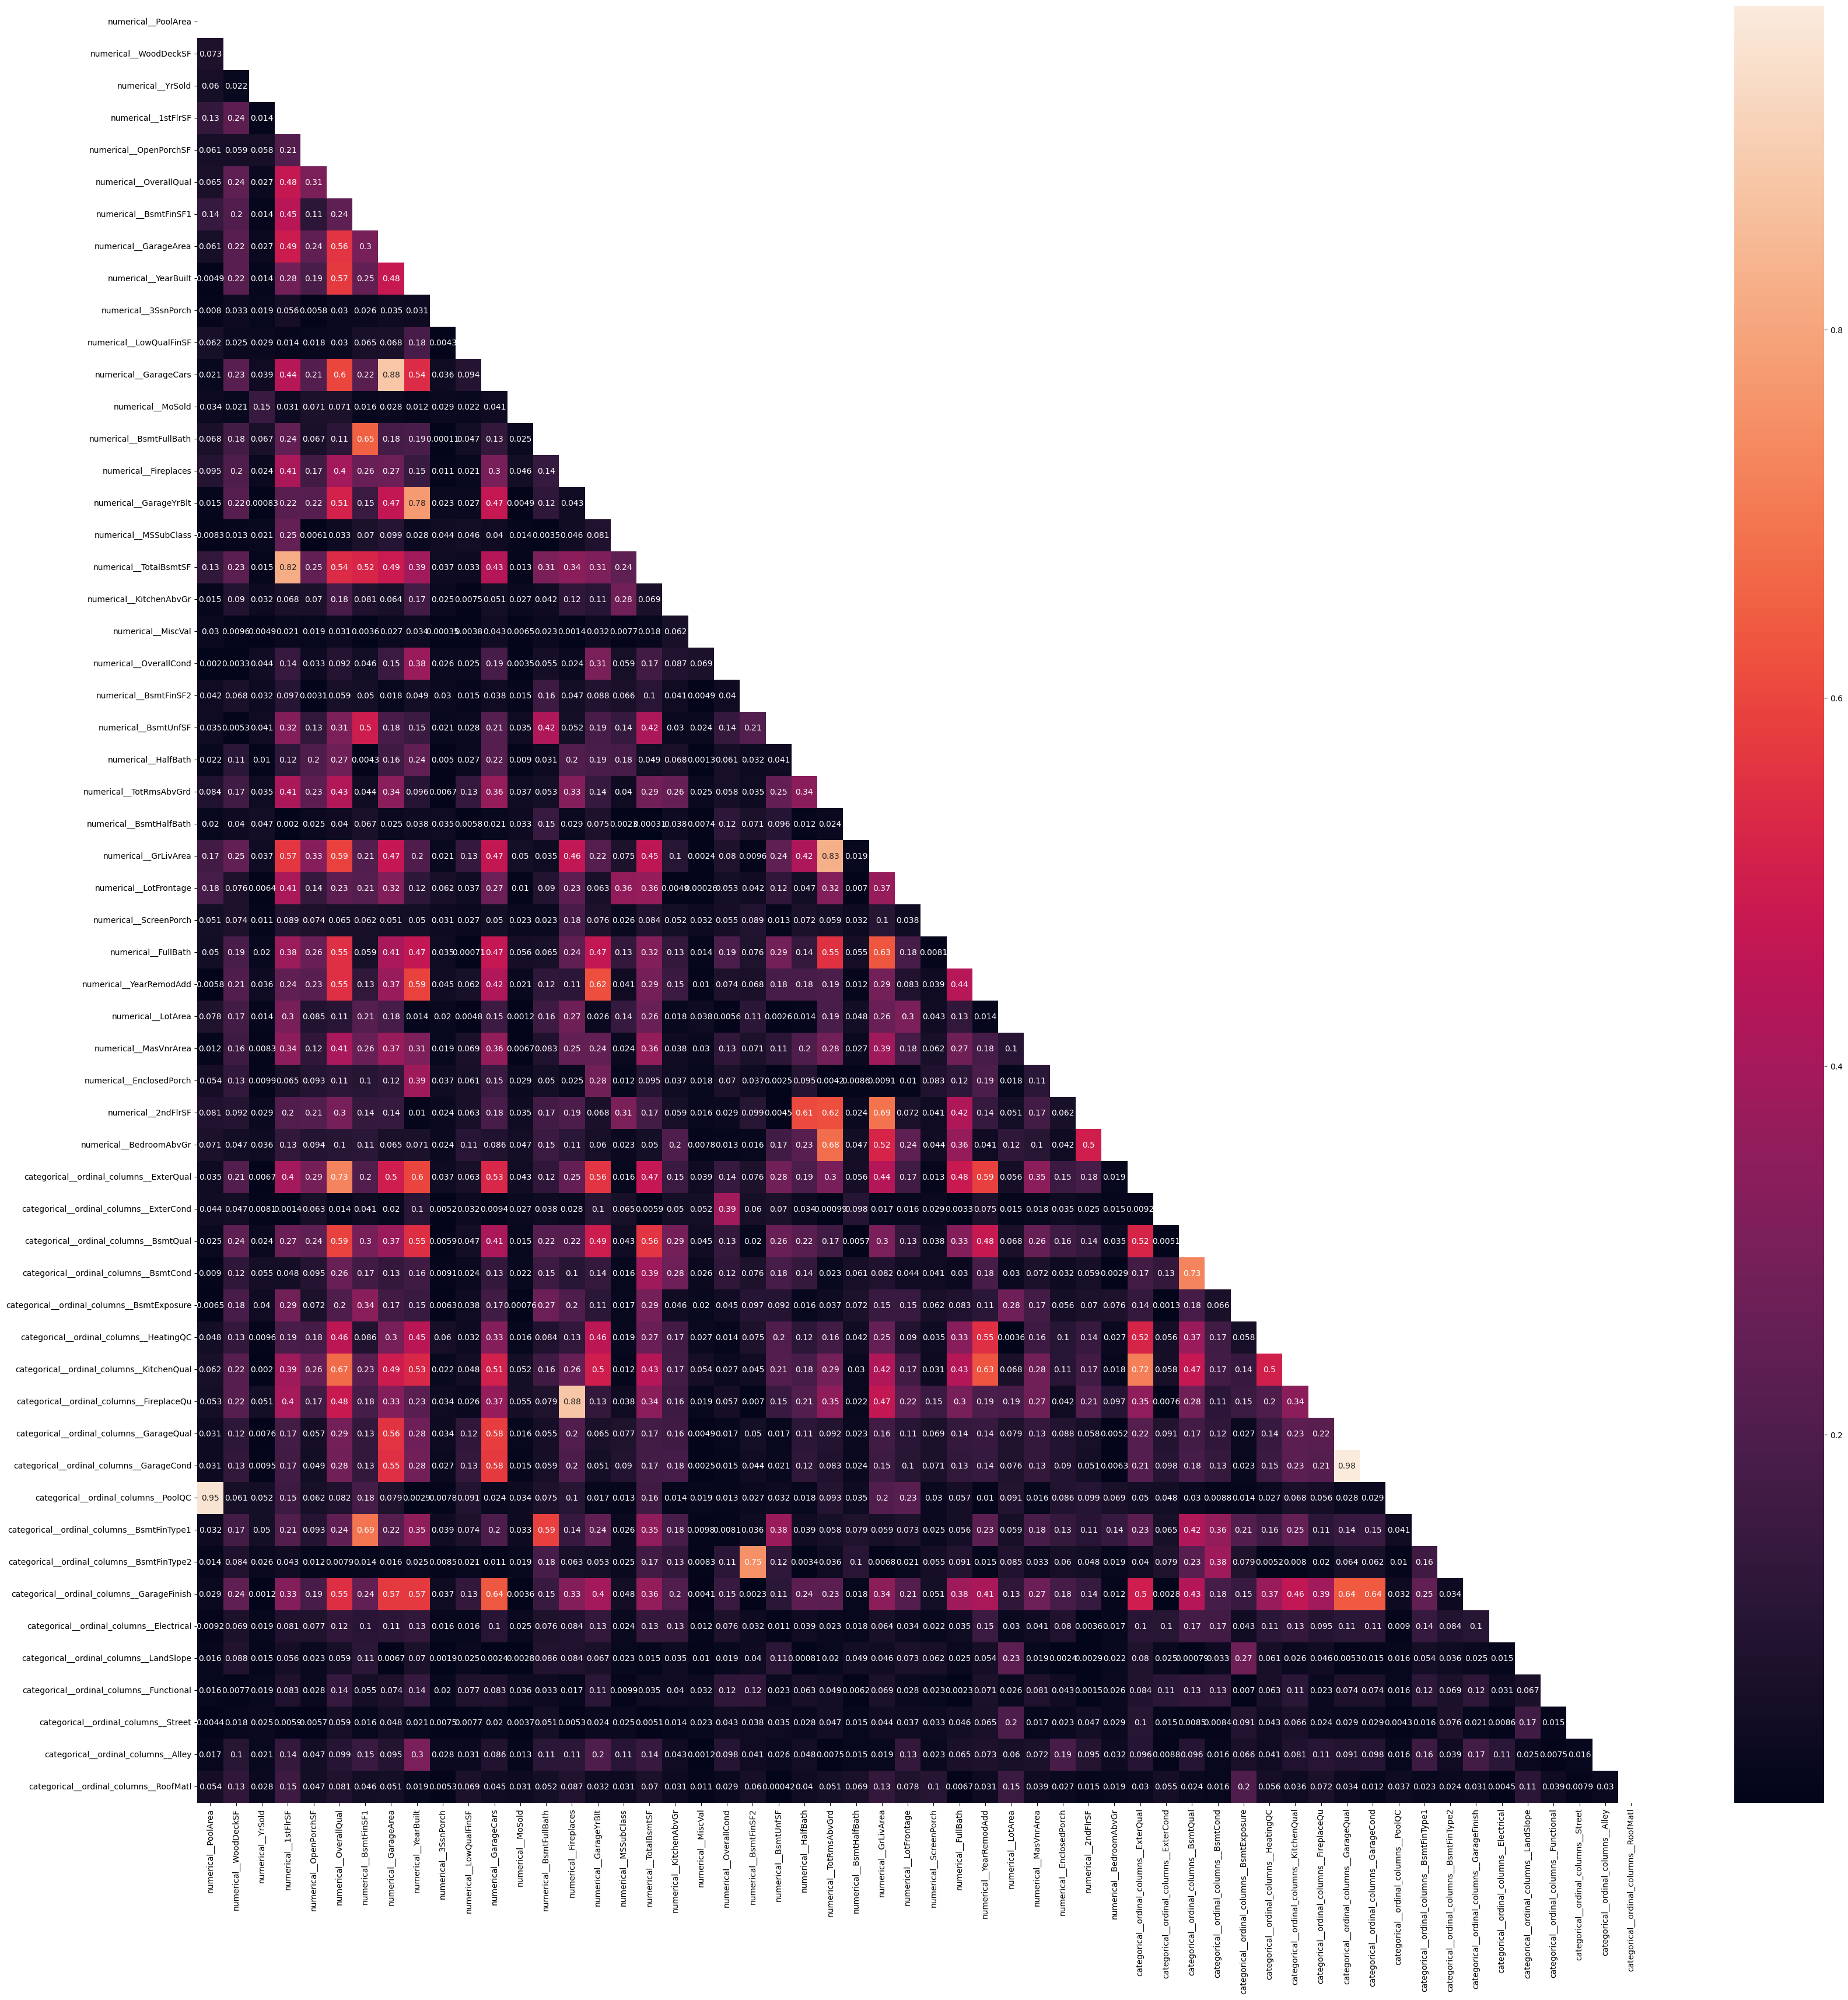

In [317]:
plot_data = data.copy()
categorical_transformer.set_output(transform='pandas')
preprocessing.set_output(transform="pandas")
plot_data_prepared = preprocessing.fit_transform(plot_data)

OH_pr = [col for col in plot_data_prepared.columns if 'categorical__OH_columns' in col]
plot_data_full = plot_data_prepared.drop(OH_pr, axis=1)

plotX = plot_data_full.corr().abs()

matrix = np.triu(np.ones_like(plotX))

plt.figure(figsize=(40,40))
sns.heatmap(plotX, annot=True, mask=matrix)

There are some highly correlated features, removing them made the model perform slightly worse, although it was more performant. I decided to leave them since it is not a big dataset.

Working model:

In [241]:
preprocessing.set_params(numerical__strategy='median')
full_pipeline.set_params(model__n_estimators=1000, model__max_depth=3, 
                         model__learning_rate=0.05, model__max_leaves=4, 
                         model__grow_policy='lossguide',  model__reg_lambda=0.2)
full_pipeline.fit(X_train, y_train)
display(full_pipeline)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['MiscVal', 'ScreenPorch',
                                                   'TotRmsAbvGrd', 'YrSold',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'BsmtUnfSF', '1stFlrSF',
                                                   'GarageArea', 'OpenPorchSF',
                                                   'BsmtFinSF2', 'PoolArea',
                                                   'MSSubClass', 'LotArea',
                                                   'OverallCond', 'MoSold',
                                                   'OverallQual', 'WoodDeckSF',
                                                   'BedroomAbvGr', 'H...
                              grow_policy='lossguide', importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=4, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

Using grid search to find best parameters, I fine tuned them by hand later.

In [ ]:
parameters = {
    'model__n_estimators': [600, 700, 1000, 1500, 2000, 2500, 3000], 
    'model__max_depth': [2,3,4], 
    'model__learning_rate': [0.005, 0.01, 0.05, 0.7, 0.1],
    'model__model__max_leaves': [3, 4, 5, 6],
    'model__reg_lambda': [0.1, 0.2, 0.6, 0.9]
    }

clf = GridSearchCV(estimator=full_pipeline, param_grid=parameters, n_jobs=-1)

clf.fit(X=X, y=Y)

In [274]:
clf.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['PoolArea', 'WoodDeckSF',
                                                   'YrSold', '1stFlrSF',
                                                   'OpenPorchSF', 'OverallQual',
                                                   'BsmtFinSF1', 'GarageArea',
                                                   'YearBuilt', '3SsnPorch',
                                                   'LowQualFinSF', 'GarageCars',
                                                   'MoSold', 'BsmtFullBath',
                                                   'Fireplaces', 'GarageYrBlt',
                                                   'MSSubClass', 'TotalBsmtSF',
                                                   'KitchenAb...
                              grow_policy='lossguide', importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=4, min_child_weight=None,
                              missing=nan, model__max_leaves=3,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=2000, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [242]:
preds = full_pipeline.predict(X_valid)
pred_error = mean_absolute_error(y_valid, preds)
pred_error

14207.266387521404

In [243]:
target_mean = y_valid.mean()
target_mean

175772.61301369863

In [244]:
(target_mean - pred_error) / target_mean

0.9191724686574798

The mean absolute error is within 92% of the mean of the target validation data

In [235]:
preds_test = full_pipeline.predict(X_test)

In [236]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)